In [1]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_supra_beta_drives, rescale_pyr_morph
sns.set()

In [2]:
%%capture
scaling_factors = [1, .8, .5]
props = ['L']
pyr_cells = ['L2_pyramidal', 'L5_pyramidal']
omit_compartments = ['basal_1',  'basal_2',  'basal_3',  'soma']

net_list = list()
dpl_list = list()
for scaling_factor in scaling_factors:
    net = calcium_model()
    add_supra_beta_drives(net, beta_start=200, strength=1)
    for prop in props:        
        if prop == 'cm':
            new_fctr = 1/scaling_factor
        else:
            new_fctr = scaling_factor
        rescale_pyr_morph(net=net, cell_types=pyr_cells, compartment_prop=prop, scaling_factor=new_fctr,
                          omit_compartment=omit_compartments)
    with MPIBackend(n_procs=10):
        dpl = simulate_dipole(net, tstop=500)[0]
    
    dpl.data['agg']  -= dpl.data['agg'][4000] # subtract baseline at 100 ms (assuming dt=0.05)
    net_list.append(net.copy())
    dpl_list.append(dpl.copy())

for idx, dpl in enumerate(dpl_list):

    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6), constrained_layout=True)
    plot_dipole(dpl, ax=axes[0], layer='agg', show=False)
    net.cell_response.plot_spikes_hist(ax=axes[1], show=False)
    net.cell_response.plot_spikes_raster(ax=axes[2], show=False)
    
    fig.savefig(f'length_apical_only_ca_model_beta_{scaling_factors[idx]}_dend.png')

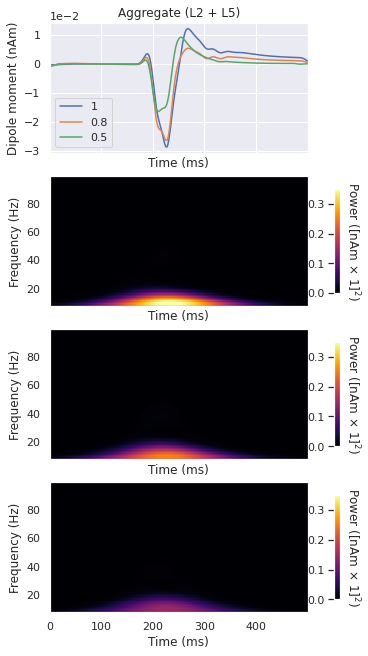

In [6]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(5, 9), constrained_layout=True)
plot_dipole([dpl.copy().smooth(30) for dpl in dpl_list], ax=axes[0], show=False)
axes[0].legend(scaling_factors)
freqs = np.arange(8, 100)
for idx, dpl in enumerate(dpl_list):
    dpl.copy().smooth(30).plot_tfr_morlet(freqs, ax=axes[1 + idx], power_lim=[0, 0.35], show=False)
fig.savefig(f'length_apical_only_ca_model_beta_comparison.png')